In [1]:
import sys; sys.path.append("..")
from importlib import reload
import persist_to_disk as ptd
import os
ptd.config.set_project_path(os.path.abspath("../"))
import tqdm
import pandas as pd
import numpy as np
import re
import torch

import utils

import matplotlib.pyplot as plt
%matplotlib inline

## Read the toy data

In [2]:
pd.__version__

'1.5.3'

In [3]:
data_path = './demo_data.pkl'
if not os.path.isfile(data_path):
    import models
    import dataeval.load as dload
    import _settings
    tokenizer = models.load_tokenizer('llama-13b-hf')
    res = dload.read_cleaned_outputs_new(_settings.GEN_PATHS['trivia']['llama-13b'])
    idx = np.random.RandomState(42).choice(len(res), 500, replace=False)
    demo_data = []
    for _idx in idx:
        curr = {_k: res[_idx][_k] for _k in ['prompt', 'id', 'question', 'answer', 'generations']}
        curr['prompt'] = tokenizer.decode(curr['prompt'])
        curr['generations'] = {_k: _v for _k, _v in curr['generations'].items() if _k.startswith("text")}
        demo_data.append(curr)
    pd.to_pickle(demo_data, data_path)
demo_data = pd.read_pickle(data_path)[:10]

## UQ object

In [4]:
import pipeline.uq_bb as uq_bb
reload(uq_bb)
obj = uq_bb.UQ_summ(demo_data, clean=True,
                    #split='test', cal_size=5, seed=1,
                   gpteval_examples = [{'question': 'In Scotland a bothy/bothie is a?',
                      'reference': 'House','answer': 'House',
                        },
                      {'question': 'Where in England was Dame Judi Dench born?',
                       'reference':  'York', 'answer': 'London'
                        }])
# when split is not set, uses the default hyperparameters

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [5]:
_ea, _ia = obj.get_acc('generations|gpt|acc')
print("Expected Accuracy (mean over all generations)")
_ea

Expected Accuracy (mean over all generations)


qw_8385       1.00
odql_1190     0.60
dpql_5542     0.15
bb_7939       0.05
sfq_10890     1.00
wh_119        0.85
qz_3903       0.75
odql_10521    0.40
sfq_6051      0.75
tc_2926       0.60
dtype: float64

In [6]:
print("Individual Accuracy")
_ia

Individual Accuracy


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
qw_8385,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
odql_1190,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0
dpql_5542,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
bb_7939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
sfq_10890,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
wh_119,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
qz_3903,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
odql_10521,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
sfq_6051,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0
tc_2926,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0


In [7]:
_u, _c = obj.get_uq('generations|eccentricity|agreement_w', temperature=3., eigv_threshold=0.9)
print("Uncertainty (higher=more uncertain)")
_u

Uncertainty (higher=more uncertain)


qw_8385       6.664002e-08
odql_1190     2.000118e+00
dpql_5542     3.162385e+00
bb_7939       3.162295e+00
sfq_10890     2.845327e-02
wh_119        2.236856e+00
qz_3903       2.001920e+00
odql_10521    2.828428e+00
sfq_6051      2.000127e+00
tc_2926       2.449579e+00
dtype: float32

In [8]:
print("(Negative) Confidence (higher=less confident)")
_c

(Negative) Confidence (higher=less confident)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
qw_8385,1.490116e-08,1.490116e-08,1.490116e-08,1.490116e-08,1.490116e-08,1.490116e-08,1.490116e-08,1.490116e-08,1.490116e-08,1.490116e-08,1.490116e-08,1.490116e-08,1.490116e-08,1.490116e-08,1.490116e-08,1.490116e-08,1.490116e-08,1.490116e-08,1.490116e-08,1.490116e-08
odql_1190,1.819493e-01,9.582773e-01,1.819493e-01,1.819493e-01,5.220483e-01,1.819493e-01,1.819493e-01,7.641149e-01,3.419343e-01,1.819493e-01,5.220483e-01,1.819493e-01,1.819493e-01,9.568827e-01,1.819493e-01,1.819493e-01,1.819493e-01,1.819493e-01,5.220483e-01,5.008894e-01
dpql_5542,6.706752e-01,3.943081e-01,9.717873e-01,9.290712e-01,6.769052e-01,9.738278e-01,5.318777e-01,6.647218e-01,3.943081e-01,5.318777e-01,9.746459e-01,6.706811e-01,6.706811e-01,3.943081e-01,4.754258e-01,6.706752e-01,9.745370e-01,9.742789e-01,3.943081e-01,5.318777e-01
bb_7939,3.415489e-01,9.746788e-01,9.746699e-01,3.415489e-01,9.678646e-01,4.022551e-01,9.746706e-01,3.415489e-01,3.415489e-01,4.022551e-01,3.415489e-01,4.022551e-01,9.746723e-01,9.745713e-01,3.412946e-01,9.746705e-01,9.746759e-01,9.746712e-01,3.415489e-01,4.022552e-01
sfq_10890,2.120584e-03,2.120584e-03,2.120584e-03,2.120584e-03,2.120584e-03,1.935552e-02,2.120584e-03,2.120584e-03,2.120584e-03,2.120584e-03,2.120584e-03,2.120584e-03,2.120584e-03,1.881512e-02,2.120584e-03,2.120584e-03,2.120584e-03,2.120584e-03,2.120584e-03,2.120584e-03
wh_119,8.535766e-01,2.585087e-01,1.815393e-01,1.815393e-01,1.815393e-01,4.396861e-01,9.399810e-01,1.815393e-01,6.841208e-01,3.134305e-01,4.114778e-01,4.250215e-01,1.815393e-01,1.815393e-01,9.691008e-01,1.815393e-01,1.815393e-01,1.815393e-01,1.815393e-01,9.727679e-01
qz_3903,9.287080e-01,1.560865e-01,1.560865e-01,1.560865e-01,4.812409e-01,1.560865e-01,1.560865e-01,1.560865e-01,2.034508e-01,1.560865e-01,1.560865e-01,4.812409e-01,9.166278e-01,1.560865e-01,8.478925e-01,1.560865e-01,8.745071e-01,1.560865e-01,1.560865e-01,1.560865e-01
odql_10521,9.746689e-01,5.335014e-01,9.746667e-01,3.047009e-01,5.306165e-01,9.746785e-01,3.047009e-01,3.047009e-01,9.745981e-01,5.255893e-01,6.613598e-01,3.047009e-01,3.047009e-01,3.047009e-01,5.377716e-01,9.740143e-01,3.047009e-01,5.367559e-01,6.810217e-01,5.298037e-01
sfq_6051,5.322726e-01,2.207384e-01,1.804645e-01,2.207384e-01,4.914243e-01,2.207384e-01,4.914243e-01,2.207384e-01,2.207384e-01,1.225779e-01,5.322726e-01,2.207384e-01,1.804645e-01,9.716102e-01,2.207384e-01,2.207384e-01,5.048478e-01,9.746709e-01,2.207384e-01,5.322726e-01
tc_2926,3.063662e-01,9.744878e-01,3.063662e-01,9.361957e-01,2.291962e-01,3.063662e-01,9.745576e-01,5.322551e-01,2.349257e-01,2.155650e-01,2.267442e-01,3.465441e-01,7.372238e-01,9.746240e-01,1.764799e-01,3.063663e-01,2.348824e-01,5.322551e-01,3.063663e-01,5.322551e-01


## Summary

In [9]:
num_gens = 10
summ_kwargs = {
    'u+ea': {'overall': True, 'use_conf': False},
    'u+ia': {'overall': False, 'use_conf': False},
    'c+ia': {'overall': False, 'use_conf': True},
}['c+ia']

summ_obj = obj.summ([
        'generations|numsets', 'lexical_sim',
    
        'generations|spectral_eigv_clip|disagreement_w',
        'generations|eccentricity|disagreement_w',
        'generations|degree|disagreement_w',

        'generations|spectral_eigv_clip|agreement_w',
        'generations|eccentricity|agreement_w',
        'generations|degree|agreement_w',


        'generations|spectral_eigv_clip|jaccard',
        'generations|eccentricity|jaccard',
        'generations|degree|jaccard',
], 
    
    acc_name='generations|gpt|acc',
    num_gens=num_gens, **summ_kwargs
)

In [10]:
# U + EA (using uncertainty to predict expected accuarcy)
summ_obj.summ_overall('auarc')

acc                                               0.615000
_cnt                                             10.000000
oracle                                            0.840765
blind                                             0.615000
generations|numsets                               0.779209
lexical_sim                                       0.771720
generations|spectral_eigv_clip|disagreement_w     0.800736
generations|eccentricity|disagreement_w           0.789658
generations|degree|disagreement_w                 0.811847
generations|spectral_eigv_clip|agreement_w        0.815816
generations|eccentricity|agreement_w              0.814916
generations|degree|agreement_w                    0.819546
generations|spectral_eigv_clip|jaccard            0.828250
generations|eccentricity|jaccard                  0.792033
generations|degree|jaccard                        0.814824
dtype: float64

In [11]:
# C + IA (using confidence to predict individual accuracy)
sum(summ_obj.summ_individual('auarc', use_conf=True)) / num_gens

acc                                               0.630000
_cnt                                             10.000000
oracle                                            0.900807
blind                                             0.630000
generations|numsets                               0.791318
lexical_sim                                       0.782945
generations|spectral_eigv_clip|disagreement_w     0.807059
generations|eccentricity|disagreement_w           0.816058
generations|degree|disagreement_w                 0.839599
generations|spectral_eigv_clip|agreement_w        0.822403
generations|eccentricity|agreement_w              0.883051
generations|degree|agreement_w                    0.870952
generations|spectral_eigv_clip|jaccard            0.839334
generations|eccentricity|jaccard                  0.862901
generations|degree|jaccard                        0.880163
dtype: float64

In [12]:
# C + IA (using confidence to predict individual accuracy)
sum(summ_obj.summ_individual('auroc', use_conf=True)) / num_gens

acc                                               0.630000
_cnt                                             10.000000
generations|numsets                               0.776500
lexical_sim                                       0.689512
generations|spectral_eigv_clip|disagreement_w     0.804238
generations|eccentricity|disagreement_w           0.820893
generations|degree|disagreement_w                 0.871024
generations|spectral_eigv_clip|agreement_w        0.821857
generations|eccentricity|agreement_w              0.960310
generations|degree|agreement_w                    0.942571
generations|spectral_eigv_clip|jaccard            0.857631
generations|eccentricity|jaccard                  0.895762
generations|degree|jaccard                        0.953696
dtype: float64

## Plots

Text(0.5, 1.0, 'ROC')

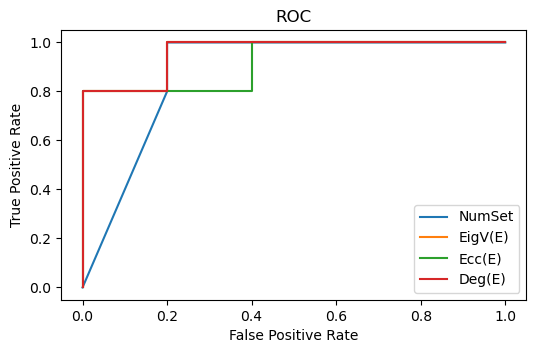

In [13]:
reload(uq_bb)
plt.figure(figsize=(6, 3.5))
def name_map(v):
    if v == 'self_prob': return "P(true)"
    v = v.replace("|disagreement_w", "|(C)")
    v = v.replace("|agreement_w", "|(E)")
    v = v.replace("|jaccard", "|(J)")
    v = v.replace("spectral_eigv_clip|", "EigV")
    v = v.replace("eccentricity|", "Ecc")
    v = v.replace("degree|", "Deg")
    return {'numsets': 'NumSet', 'semanticEntropy|unnorm': 'SE',
            'blind': 'Basse Accuracy'}.get(v,v)
    return v
summ_obj.plot('roc', name_map=name_map, 
              methods=[
                  'generations|numsets',
                       'generations|eccentricity|agreement_w', 
                       'generations|spectral_eigv_clip|agreement_w', 
                       'generations|degree|agreement_w', 
                  'self_prob', 'semanticEntropy|unnorm'], 
              cutoff=1, iloc=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC")


Text(0.5, 1.0, 'ARC')

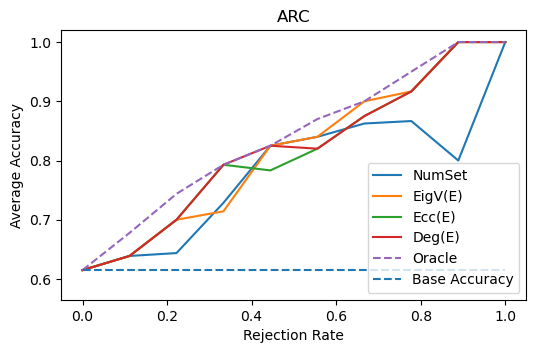

In [14]:
reload(uq_bb)
plt.figure(figsize=(6,3.5))
def name_map(v):
    if v == 'self_prob': return "P(true)"
    v = v.replace("|disagreement_w", "|(C)")
    v = v.replace("|agreement_w", "|(E)")
    v = v.replace("|jaccard", "|(J)")
    v = v.replace("spectral_eigv_clip|", "EigV")
    v = v.replace("eccentricity|", "Ecc")
    v = v.replace("degree|", "Deg")
    return {'numsets': 'NumSet', 'semanticEntropy|unnorm': 'SE', 'oracle': "Oracle",
            'blind': 'Base Accuracy'}.get(v,v)
    return v
summ_obj.plot('arc', name_map=name_map, 
              methods=[
                  'generations|numsets',
                       'generations|eccentricity|agreement_w', 
                       'generations|spectral_eigv_clip|agreement_w', 
                       'generations|degree|agreement_w', 
                       'oracle', 'blind', 'self_prob', 'semanticEntropy|unnorm'], 
              cutoff=1)
plt.xlabel("Rejection Rate")
plt.ylabel("Average Accuracy")
plt.title("ARC")
